In [1]:


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as col
import sys
sys.path.append('/pool/firebolt1/p484/projects/huang/rings')
from continuumanalysis3 import Continuum
from fitellipse import *
from analyzeradprofile import *
from astropy.visualization import ImageNormalize, SqrtStretch, AsinhStretch

In [2]:
disk = {'filename': '/data/sandrews/jhfiles/LPfiles/taperedimages/IMLup_tapered.image.fits',
                          'distance':158,
                          'incl' : 47.5, 
                          'PA' : 144.7,
                          'offsetx' : 0.63*.003,
                          'offsety' : -0.32*.003,
                          'size': 4,
                          'gamma': 0.45
                         }
maxrad = 250
radialbins = 0.5+1*np.arange(maxrad)

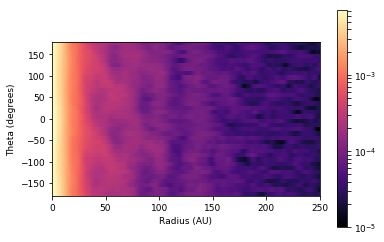

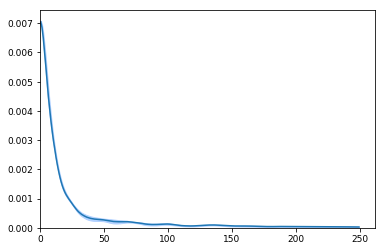

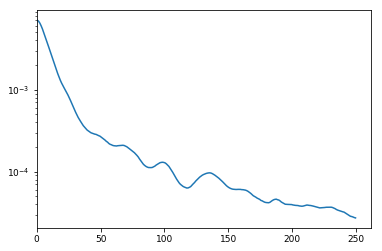

In [2]:


cont = Continuum(disk['filename'], disk['offsetx'],disk['offsety'], disk['PA'], disk['incl'], disk['distance'])

surfbrightness, SB_scatter, rtmap = cont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

plt.imshow(rtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma', norm = col.LogNorm(vmin = 1.e-5))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()

plt.plot(radialbins, surfbrightness)
plt.fill_between(radialbins,(surfbrightness - SB_scatter),(surfbrightness + SB_scatter),facecolor = '#B2D1FF',edgecolor = '#B2D1FF')
plt.xlim(xmin = 0)
plt.ylim(ymin =0)

plt.show()

plt.show()

plt.semilogy(radialbins, surfbrightness)
plt.xlim(xmin = 0)
plt.show()

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = 4.185e-04 arcsec, delta_y = 3.414e-03 arcsec
The MLE semi-major axis is r = 0.845 arcsec
The MLE inclination is i = 47.553 degrees
The MLE position angle is PA = 143.878 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -8.009e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


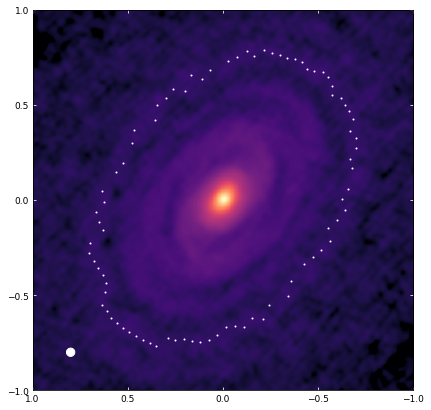

In [3]:
# Extract the ring that's at ~135 AU
xcoords1, ycoords1 = cont.extract_ring(125,140,tbins = -178+4*np.arange(90), extract_type = 'max')

cont.plot_extracted_ring(cont,xcoords1, ycoords1, 0.4, 2)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_1 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     0.8,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords1, ycoords1)

In [4]:
#do mcmc fit
def lnprior(ellipse_params):
    x0, y0, r0, cosi, par, logvar = ellipse_params
    if -4.5 < x0 < 4.5 and -4.5 < y0 < 4.5 and 0 < r0 < 4.5 and 0<cosi<1 and 0 < par < np.pi and -15<logvar<-5:
        return 0.0
    return -np.inf

def lnprob(ellipse_params, xcoord, ycoord):
    lp = lnprior(ellipse_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(ellipse_params, xcoord, ycoord)

nwalkers = 30
nthreads = 8
nsteps = 20000

In [5]:
sampler1 = run_mcmc(nwalkers, nthreads, nsteps, mle_1, lnprob, xcoords1, ycoords1)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

In [6]:
np.savez("IMLupellipsechains.npz", BR133 = sampler1.chain)

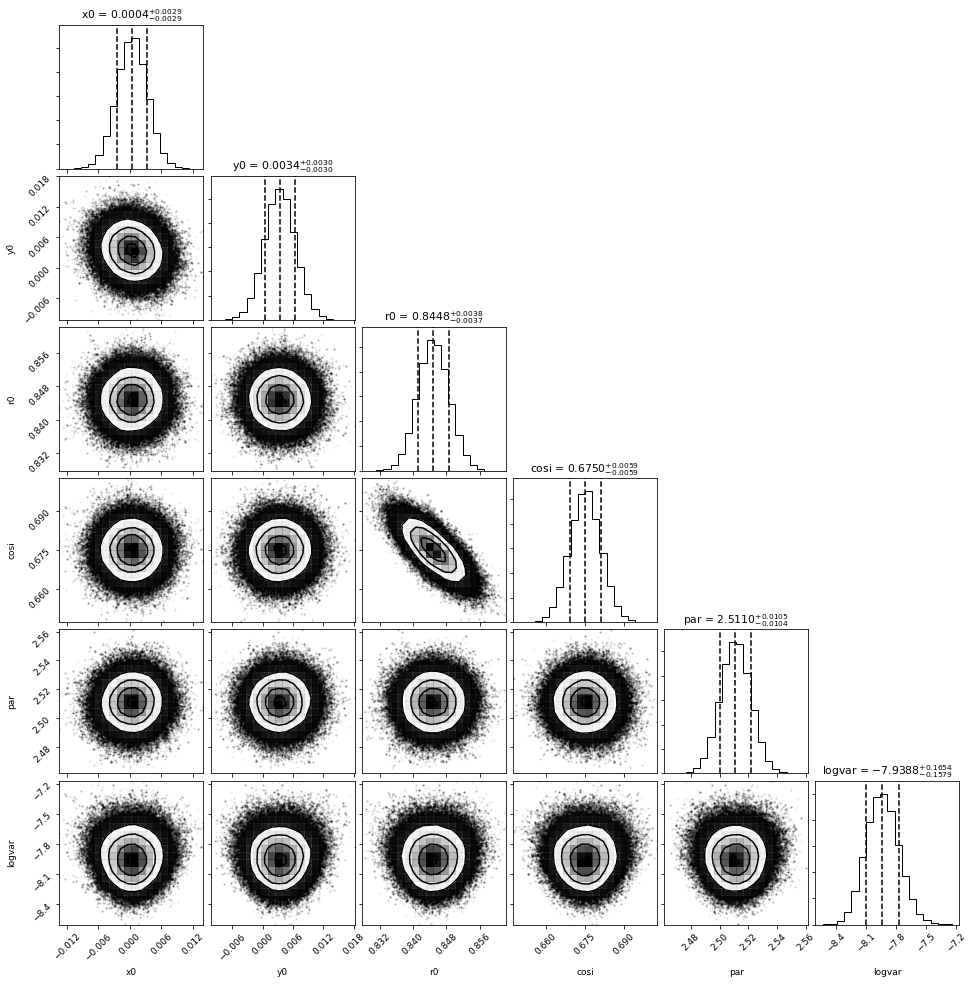

The x offset is delta_x = 4.07e-04 arcsec (+2.9e-03, -2.9e-03)
The y offset is delta_y = 3.40e-03 arcsec (+3.0e-03, -3.0e-03)
The median semi-major axis is r = 0.8448 arcsec (+0.0038, -0.0037) 
or 133.48 AU (+0.48, -0.48)
The incl is i = 47.54 deg (+0.46, -0.46)
The median position angle is PA = 143.87 deg (+0.60, -0.60)
The median log-variance in the pixel offsets from the true ellipse is -7.939e+00


In [7]:
plot_corner(sampler1, 500, 1)
sampler_results(sampler1, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = -3.374e-03 arcsec, delta_y = -1.905e-03 arcsec
The MLE semi-major axis is r = 0.743 arcsec
The MLE inclination is i = 47.453 degrees
The MLE position angle is PA = 145.184 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -8.310e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


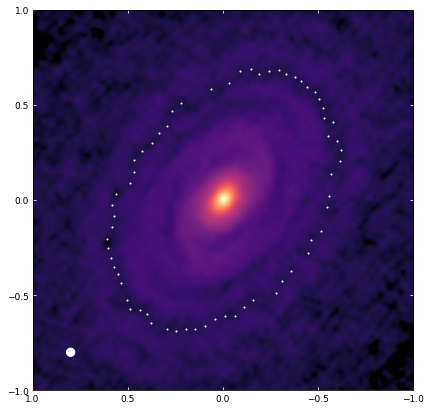

In [8]:
# Extract the gap that's at ~120 AU
xcoords2, ycoords2 = cont.extract_ring(110,125,tbins = -177.5+5*np.arange(72), extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords2, ycoords2, 0.4, 2)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_2 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     0.8,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords2, ycoords2)

In [9]:
sampler2 = run_mcmc(nwalkers, nthreads, nsteps, mle_2, lnprob, xcoords2, ycoords2)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

In [10]:
np.savez("IMLupellipsechains.npz", BR133 = sampler1.chain, DA118 = sampler2.chain)

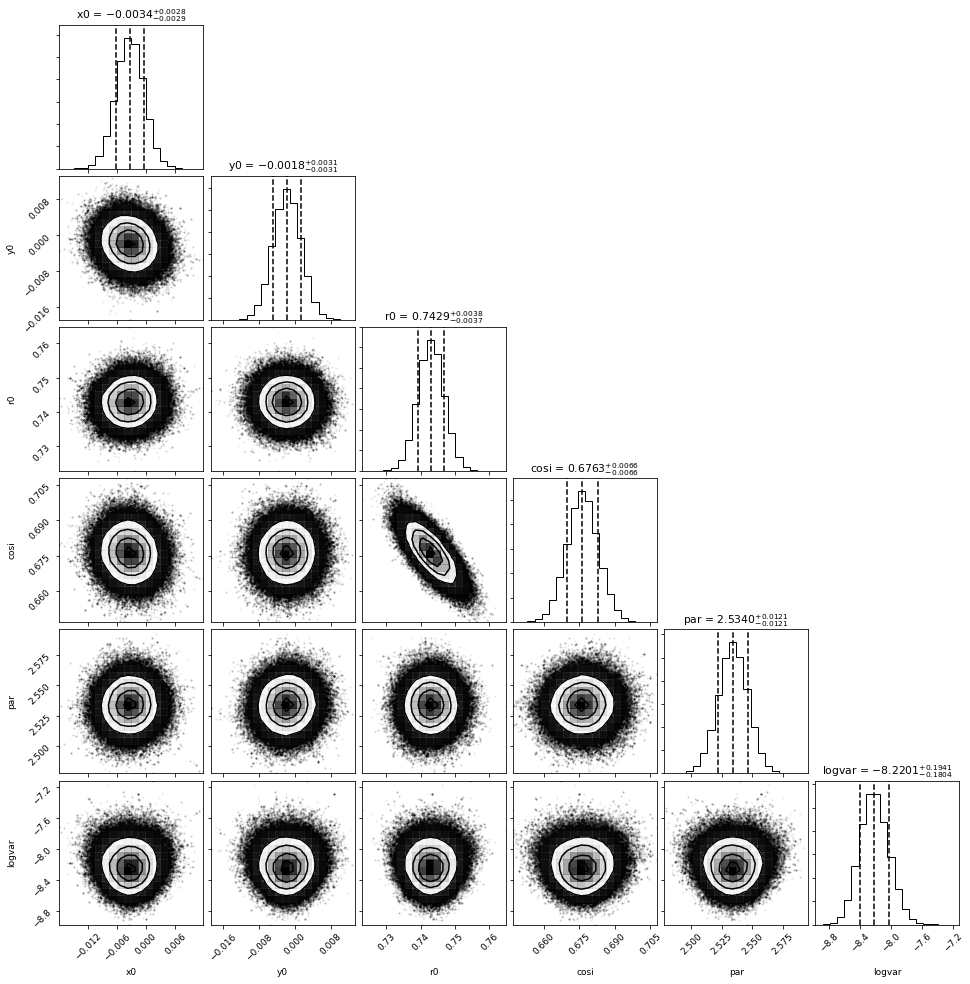

The x offset is delta_x = -3.37e-03 arcsec (+2.8e-03, -2.9e-03)
The y offset is delta_y = -1.79e-03 arcsec (+3.1e-03, -3.1e-03)
The median semi-major axis is r = 0.7429 arcsec (+0.0038, -0.0037) 
or 117.39 AU (+0.49, -0.49)
The incl is i = 47.45 deg (+0.51, -0.52)
The median position angle is PA = 145.19 deg (+0.69, -0.69)
The median log-variance in the pixel offsets from the true ellipse is -8.220e+00


In [11]:
plot_corner(sampler2, 500, 1)
sampler_results(sampler2, 500, cont.src_distance)

In [3]:
newcont = Continuum(disk['filename'], -0.0015,0.9e-3, 144.4, 47.5,disk['distance'])

In [4]:
radialbins = 0.5+np.arange(0, maxrad)
#make some preliminary plots

    
newsurfbrightness, newSB_scatter, newrtmap = newcont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))


print("max",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'max'))
print("min",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'min'))

max [67, 98, 135, 186, 212, 228]
min [62, 88, 118, 180, 207, 222]


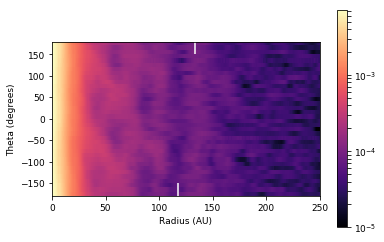

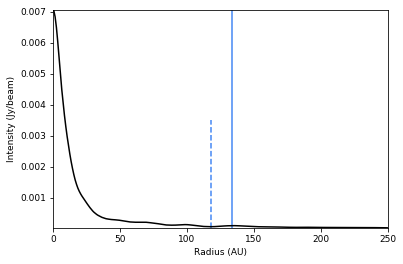

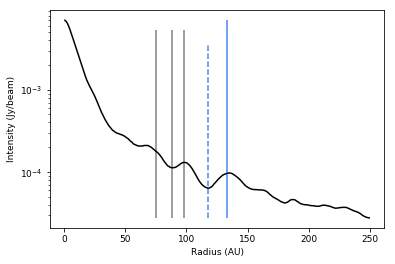

(0, 250)

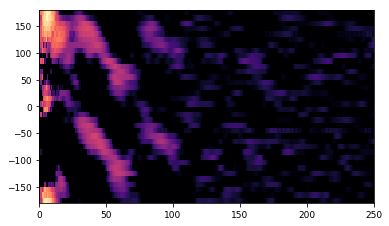

In [16]:


plt.imshow(newrtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma',  norm = col.LogNorm(vmin = 1.e-5))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
features = np.array([75,88,98])
gaps = np.array([117.6])
rings = np.array([133.4])
for gap in gaps:
    plt.vlines(gap,-180,-150, color ='white')
for ring in rings:
    plt.vlines(ring,150,180, color ='white')
for f in features:
    plt.vlines(f,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='gray')

plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()


plt.plot(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.xlim(xmin = 0, xmax = maxrad)
plt.ylim(ymin = np.min(newsurfbrightness), ymax = np.max(newsurfbrightness))
plt.show()

plt.semilogy(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),np.max(newsurfbrightness), color ='#4286f4')
for f in features:
    plt.vlines(f,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='gray')

plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.show()

plt.imshow(newrtmap-newsurfbrightness,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma', norm =  ImageNormalize(vmin = 0, stretch = AsinhStretch(0.05)))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)



In [5]:
calc_contrast(117.4, 133.5, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.6606672270206867, 0.018884798213878999)

In [6]:
measure_widths(117.4, 133.5, radialbins, newsurfbrightness, 100, 150)

7.98719613015e-05 125.6


(15.799999999999997, 18.400000000000006)

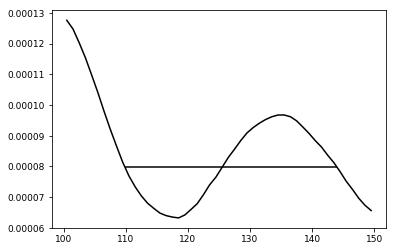

In [10]:
plt.plot(radialbins[100:150], newsurfbrightness[100:150], color = 'black')
plt.hlines(7.98719613015e-05, 125.6-15.8,125.6)
plt.hlines(7.98719613015e-05, 125.6,125.6+18.4)

263.5


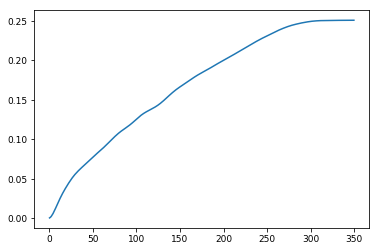

In [7]:
bins = 0.5+1*np.arange(0, 350)

cumeflux = newcont.cumefluxprofile(bins)
plt.plot(bins, cumeflux)
print(bins[np.argmin(np.abs(cumeflux-0.95*np.max(cumeflux)))])